In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34779")
client

Client Scheduler: tcp://127.0.0.1:34779 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 40 Memory: 168.99 GB


In [3]:
import numpy as np
import xarray as xr
import gsw
import time
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from MITgcmutils import jmd95
from dask.diagnostics import ProgressBar
import os.path as op
from scipy.interpolate import griddata
import scipy.sparse as spar
import scipy.signal as spsig
import scipy.ndimage as spimg
# import dask_image.ndfilters as dsfilt
import dask.array as dsar
# import xrft
# import xscale
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [4]:
rdir = '/tank/chaocean/'
ddir = '/tank/topog/tuchida/TWA/'

In [5]:
grav = 9.81
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 10
yend = 50
# sstart = 0
# send = 26
# nremap = 140
dnf = 2160
nchk = 20
nhskip = 3
nbskip = 2
nfile = 73

mchunk = 1
xchunk = 250
ychunk = 400
schunk = -1

In [13]:
def _dot3D(self, other):
    func = np.dot(self[0,0,0], other[0,0,0])
#     return np.expand_dims(func, (0,1,2))
    return func[np.newaxis,np.newaxis,np.newaxis,:,:]

def _dot2D(self, other):
    func = np.dot(self[0,0], other[0,0])
#     return np.expand_dims(func, (0,1))
    return func[np.newaxis,np.newaxis,:,:]

In [15]:
G1 = xr.DataArray(np.random.rand(5,5,5,2,3),  dims=['YC','XC','sig','row','col'])
F1 = xr.DataArray(np.random.rand(5,5,5,3,2), dims=['YC','XC','sig','row','col'])

def func(self, other):
    dot = np.dot(self[0], other[0])
    return np.expand_dims(dot, 0)

dsar.map_blocks(_dot3D, 
                G1.chunk({'YC':1,'XC':1,'sig':1}).data, 
                F1.chunk({'YC':1,'XC':1,'sig':1}).data, 
                dtype=float,
                chunks=(1,1,1, 2, 2)).compute().shape

(5, 5, 5, 2, 2)

In [16]:
years = np.arange(2008,2013,dtype=int)
ntimes = np.arange(7886160,8672400+dnf,dnf).reshape(len(years),nfile)
dd = 42
yystart = 3
ntimes[yystart,dd]

8449920

<xarray.Dataset>
Dimensions:  (XC: 1000, YC: 362, sig: 14)
Coordinates:
    Depth    (YC, XC) float32 dask.array<chunksize=(62, 500), meta=np.ndarray>
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) float64 19.92 20.0 20.08 20.17 ... 49.75 49.83 49.92 50.0
    iter     int64 ...
    maskInC  (YC, XC) int8 dask.array<chunksize=(183, 1000), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(62, 500), meta=np.ndarray>
  * sig      (sig) float64 26.23 26.53 26.81 27.06 ... 28.24 28.34 28.43 28.52
    time     timedelta64[ns] ...
Data variables:
    PVx      (YC, XC, sig) float64 dask.array<chunksize=(47, 250, 4), meta=np.ndarray>
    PVy      (YC, XC, sig) float64 dask.array<chunksize=(47, 250, 4), meta=np.ndarray>
    sx       (YC, XC, sig) float64 dask.array<chunksize=(47, 250, 4), meta=np.ndarray>
    sy       (YC, XC, sig) float64 dask.array<chunksize=(47, 250, 4), meta=np.ndarray>
    tx       (YC, XC, sig) float64 dask

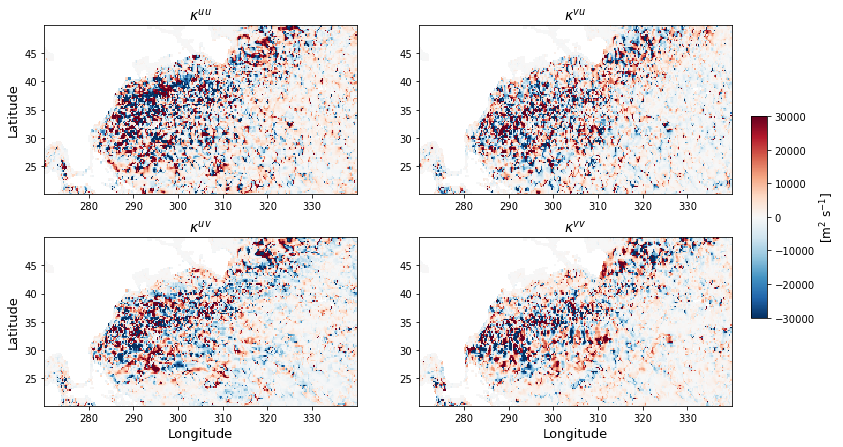

8449920
Lapse time: 2744.090791940689
8452080
Lapse time: 2745.2108283042908
8454240
Lapse time: 2765.5041103363037
8456400
Lapse time: 2775.3092727661133
8458560
Lapse time: 2773.674395799637
8460720
Lapse time: 2770.718766927719
8462880
Lapse time: 2772.3682708740234
8465040
Lapse time: 2898.2772364616394


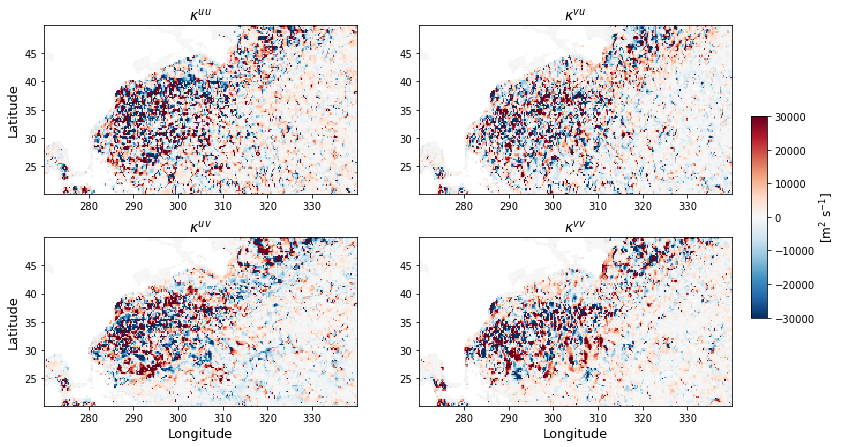

8467200
Lapse time: 2857.2972390651703
8469360
Lapse time: 2802.974166870117
8471520
Lapse time: 2824.9468698501587
8473680
Lapse time: 2888.885364294052
8475840
Lapse time: 2882.5514347553253
8478000
Lapse time: 2791.8300244808197
8480160
Lapse time: 2851.104036808014
8482320
Lapse time: 2824.54945230484
8484480
Lapse time: 2803.874005317688
8486640
Lapse time: 2838.6220066547394
8488800
Lapse time: 2750.4774026870728
8490960
Lapse time: 2884.2059123516083
8493120
Lapse time: 2877.197196006775
8495280
Lapse time: 2926.160205602646
8497440
Lapse time: 2898.7499465942383
8499600
Lapse time: 2930.7324471473694
8501760
Lapse time: 2896.4979376792908
8503920
Lapse time: 2877.20117688179
8506080
Lapse time: 2865.758581638336
8508240
Lapse time: 2784.332728624344


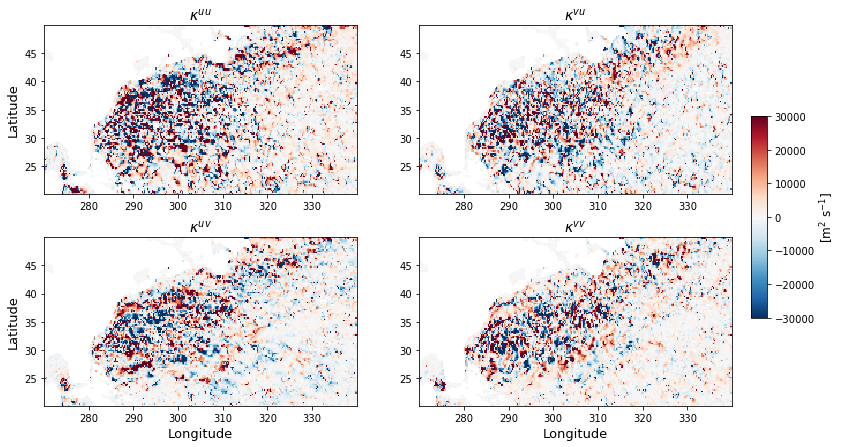

8510400
Lapse time: 2843.973503112793
8512560
Lapse time: 2857.7395298480988
8514720
<xarray.Dataset>
Dimensions:  (XC: 1000, YC: 362, sig: 14)
Coordinates:
    Depth    (YC, XC) float32 dask.array<chunksize=(62, 500), meta=np.ndarray>
  * XC       (XC) float32 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) float64 19.92 20.0 20.08 20.17 ... 49.75 49.83 49.92 50.0
    iter     int64 ...
    maskInC  (YC, XC) int8 dask.array<chunksize=(183, 1000), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(62, 500), meta=np.ndarray>
  * sig      (sig) float64 26.23 26.53 26.81 27.06 ... 28.24 28.34 28.43 28.52
    time     timedelta64[ns] ...
Data variables:
    PVx      (YC, XC, sig) float64 dask.array<chunksize=(47, 250, 4), meta=np.ndarray>
    PVy      (YC, XC, sig) float64 dask.array<chunksize=(47, 250, 4), meta=np.ndarray>
    sx       (YC, XC, sig) float64 dask.array<chunksize=(47, 250, 4), meta=np.ndarray>
    sy       (YC, XC, sig) float64 dask.a

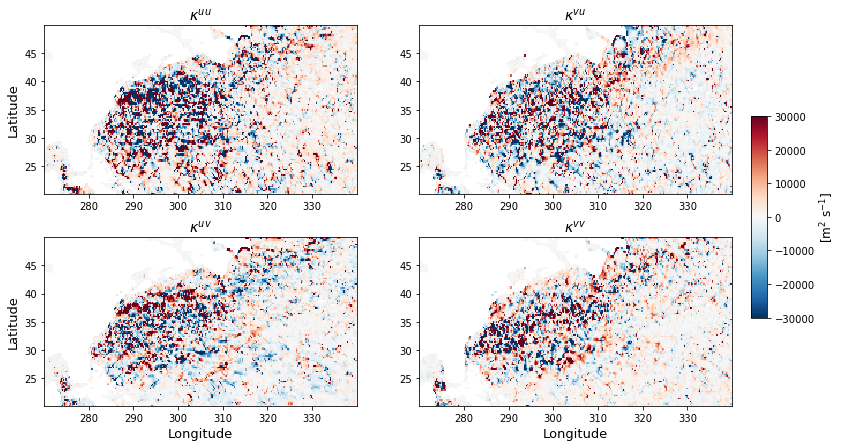

8516880
Lapse time: 2904.347192287445
8519040
Lapse time: 2888.1750009059906
8521200
Lapse time: 2928.5145530700684
8523360
Lapse time: 2875.6196627616882
8525520
Lapse time: 2861.331844329834
8527680
Lapse time: 2879.1005992889404
8529840
Lapse time: 2800.100436449051
8532000
Lapse time: 2911.8162610530853
8534160
Lapse time: 2940.443269968033
8536320
Lapse time: 2862.4032447338104
8538480
Lapse time: 2841.1986145973206
8540640
Lapse time: 2908.6678037643433
8542800
Lapse time: 2872.7580754756927
8544960
Lapse time: 2911.8426461219788
8547120
Lapse time: 2842.225895881653
8549280
Lapse time: 2897.821729183197
8551440
Lapse time: 2853.0128774642944


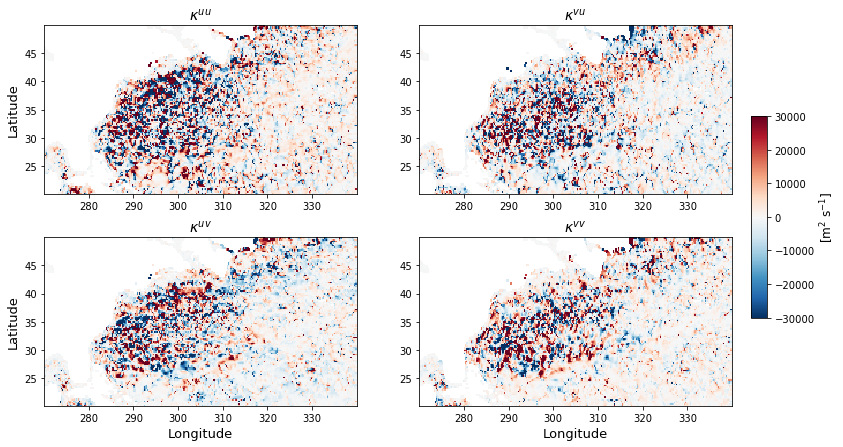

8553600
Lapse time: 2858.130987405777
8555760
Lapse time: 2922.8411242961884
8557920
Lapse time: 2790.499165534973
8560080
Lapse time: 3014.06338429451
8562240
Lapse time: 2889.6808104515076
8564400
Lapse time: 2884.0298702716827
8566560
Lapse time: 2837.35683965683
8568720
Lapse time: 2843.244781732559
8570880
Lapse time: 2937.841692209244
8573040
Lapse time: 2895.3556292057037
8575200
Lapse time: 2873.513773918152
8577360
Lapse time: 2824.8682868480682
8579520
Lapse time: 2795.4903090000153
8581680
Lapse time: 2890.474765777588
8583840
Lapse time: 2840.2301228046417
8586000
Lapse time: 2852.864233016968
8588160
Lapse time: 2874.515818119049
8590320
Lapse time: 2934.4181158542633
8592480
Lapse time: 2902.588573694229
8594640
Lapse time: 2937.1596326828003


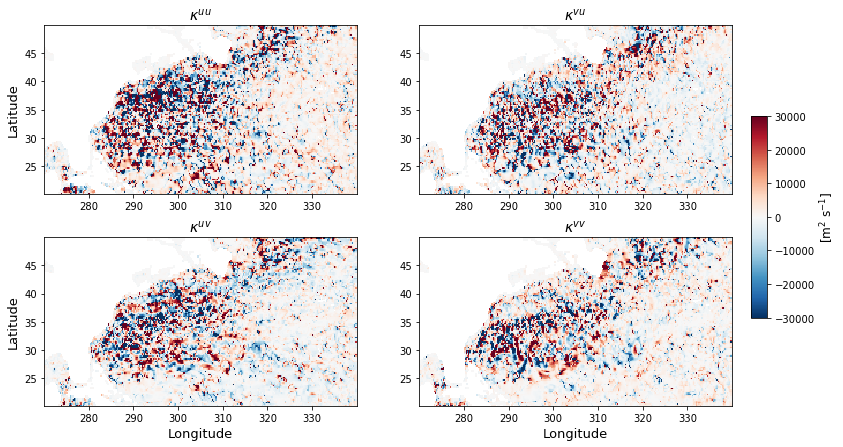

8596800
Lapse time: 2956.4371881484985
8598960
Lapse time: 2885.488977432251
8601120
Lapse time: 2886.5680973529816
8603280
Lapse time: 2891.775981426239
8605440
Lapse time: 2863.823051214218
8607600
Lapse time: 2879.180436849594
8609760
Lapse time: 2908.407078742981
8611920
Lapse time: 2861.2410225868225
8614080
Lapse time: 2943.593285560608
8616240
Lapse time: 2882.434315919876
8618400
Lapse time: 2931.3579466342926
8620560
Lapse time: 2883.0611147880554
8622720
Lapse time: 2868.207114458084
8624880
Lapse time: 2868.5568006038666
8627040
Lapse time: 2861.8966970443726
8629200
Lapse time: 2905.2929162979126
8631360
Lapse time: 2942.43501329422
8633520
Lapse time: 2925.9142124652863
8635680
Lapse time: 2904.912171125412
8637840
Lapse time: 2938.2440819740295


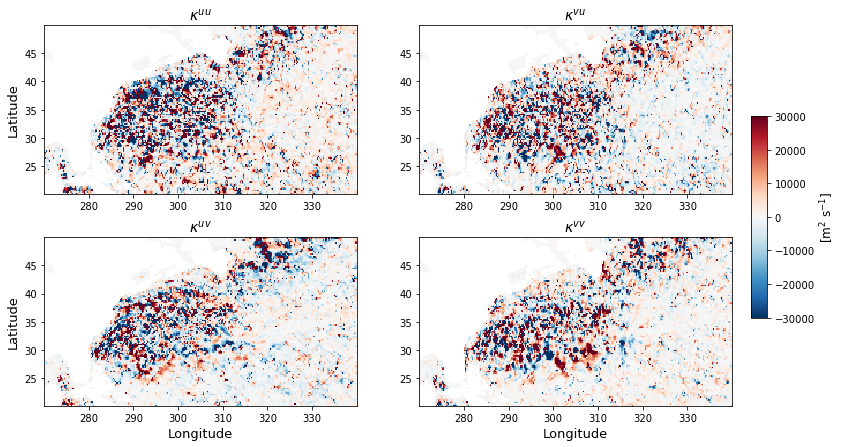

8640000
Lapse time: 3002.2300255298615
8642160
Lapse time: 2945.1653015613556
8644320
Lapse time: 2989.9550569057465
8646480
Lapse time: 2989.7992186546326
8648640
Lapse time: 2869.3436150550842
8650800
Lapse time: 2916.717640399933
8652960
Lapse time: 2924.558968067169
8655120
Lapse time: 2981.59117603302
8657280
Lapse time: 2993.7593829631805
8659440
Lapse time: 2862.049500465393
8661600
Lapse time: 2863.103236913681
8663760
Lapse time: 2883.9113178253174
8665920
Lapse time: 3000.6322021484375
8668080
Lapse time: 2994.386205434799
8670240
Lapse time: 3022.6445722579956
8672400


In [17]:
# isig = np.arange(sstart,send+nbskip,nbskip,dtype=int)
yy = yystart
xlim = [270,340]

for year in years[yystart:]:
    if year == years[yystart]:
        mtimes = ntimes[yy,dd:]
        ystart = yNstart
    else:
        mtimes = ntimes[yy]
        ystart = yNstart
    for itime in mtimes:

        dsfx = xr.open_zarr(op.join(ddir,'5Dave/run%4d/Norm-fluxes/%010d' 
                                    % (year,itime))
                           ).sel(YC=slice(yNstart+10-12**-1,yend+12**-1))
        dsfx = dsfx.isel(sig=np.arange(0,len(dsfx.sig),nbskip,dtype=int))
        if itime == mtimes[0]:
            print(dsfx)

##############################
##############################
        K = xr.DataArray(np.ones((len(dsfx.YC[::nhskip]),
                                  len(dsfx.XC[::nhskip].sel(XC=slice(xlim[0],xlim[1]))),
                                  len(dsfx.sig[:]),2,2))*np.nan,
                         dims=['YC','XC','sig','row','col'],
                         coords={'YC':dsfx.YC[::nhskip].data,
                                 'XC':dsfx.XC[::nhskip].sel(XC=slice(xlim[0],xlim[1])).data,
                                 'sig':dsfx.sig[:].data}
                        )


        start = time.time()
        G = xr.DataArray(np.ones((len(dsfx.YC[::nhskip].data),
                                  len(dsfx.XC[::nhskip].sel(XC=slice(xlim[0],xlim[1])).data),
                                  len(dsfx.sig[:]),3,2))*np.nan,
                         dims=['YC','XC','sig','row','col']
                        )
        G[:,:,:,0,0] = -dsfx.tx[::nhskip,::nhskip,:].sel(XC=slice(xlim[0],xlim[1]))
        G[:,:,:,0,1] = -dsfx.ty[::nhskip,::nhskip,:].sel(XC=slice(xlim[0],xlim[1]))
        G[:,:,:,1,0] = -dsfx.sx[::nhskip,::nhskip,:].sel(XC=slice(xlim[0],xlim[1]))
        G[:,:,:,1,1] = -dsfx.sy[::nhskip,::nhskip,:].sel(XC=slice(xlim[0],xlim[1]))
        G[:,:,:,2,0] = -dsfx.PVx[::nhskip,::nhskip,:].sel(XC=slice(xlim[0],xlim[1]))
        G[:,:,:,2,1] = -dsfx.PVy[::nhskip,::nhskip,:].sel(XC=slice(xlim[0],xlim[1]))

        invG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, 
                                            G.chunk({'YC':1,'XC':1,'sig':1}).data).compute(),
                            dims=['YC','XC','sig','row','col']
                           )
        del G
        
        F = xr.DataArray(np.ones((len(dsfx.YC[::nhskip].data),
                                  len(dsfx.XC[::nhskip].sel(XC=slice(xlim[0],xlim[1])).data),
                                  len(dsfx.sig[:]),3,2))*np.nan,
                         dims=['YC','XC','sig','row','col']
                        )
        F[:,:,:,0,0] = dsfx.uptp[::nhskip,::nhskip,:].sel(XC=slice(xlim[0],xlim[1]))
        F[:,:,:,0,1] = dsfx.vptp[::nhskip,::nhskip,:].sel(XC=slice(xlim[0],xlim[1]))
        F[:,:,:,1,0] = dsfx.upsp[::nhskip,::nhskip,:].sel(XC=slice(xlim[0],xlim[1]))
        F[:,:,:,1,1] = dsfx.vpsp[::nhskip,::nhskip,:].sel(XC=slice(xlim[0],xlim[1]))
        F[:,:,:,2,0] = dsfx.upPVp[::nhskip,::nhskip,:].sel(XC=slice(xlim[0],xlim[1]))
        F[:,:,:,2,1] = dsfx.vpPVp[::nhskip,::nhskip,:].sel(XC=slice(xlim[0],xlim[1]))

        K[:] = dsar.map_blocks(_dot3D, invG.chunk({'YC':1,'XC':1,'sig':1}).data, 
                               F.chunk({'YC':1,'XC':1,'sig':1}).data,
                               chunks=(1,1,1,2,2)
                              ).compute()
        
        del F, invG
        end = time.time()
        print('Lapse time:', end-start)
        K.to_dataset(name='K').to_netcdf(op.join(ddir,
                                '5Dave/run%4d/Kappas_isig%02d-%02d_nhskip%1d_nbskip%1d_%010d.nc' 
                                         % (year,23,49,nhskip,nbskip,itime)), mode='w')

##############################
        if itime == mtimes[0] or itime % (20*dnf) == 0:
            fig, axes = plt.subplots(figsize=(13,7), nrows=2, ncols=2)
            im0 = axes[0,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+10,yend)), 
                                       K.isel(sig=1)[:,:,0,0].sel(YC=slice(yNstart+10,yend)), 
                                       vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
            im1 = axes[0,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+10,yend)), 
                                       K.isel(sig=1)[:,:,0,1].sel(YC=slice(yNstart+10,yend)), 
                                       vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
            im2 = axes[1,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+10,yend)),
                                       K.isel(sig=1)[:,:,1,0].sel(YC=slice(yNstart+10,yend)), 
                                       vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
            im3 = axes[1,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+10,yend)), 
                                       K.isel(sig=1)[:,:,1,1].sel(YC=slice(yNstart+10,yend)), 
                                       vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
            axes[0,0].set_title(r"$\kappa^{uu}$", fontsize=14)
            axes[0,1].set_title(r"$\kappa^{vu}$", fontsize=14)
            axes[1,0].set_title(r"$\kappa^{uv}$", fontsize=14)
            axes[1,1].set_title(r"$\kappa^{vv}$", fontsize=14)
            axes[1,0].set_xlabel(r"Longitude", fontsize=13)
            axes[1,1].set_xlabel(r"Longitude", fontsize=13)
            axes[0,0].set_ylabel(r"Latitude", fontsize=13)
            axes[1,0].set_ylabel(r"Latitude", fontsize=13)
            fig.subplots_adjust(right=0.86, hspace=.26) 
            cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
            cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
            cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)
            plt.show()
            plt.savefig(op.join(ddir,
                            'Figures/Kappas_5Dave_isig25_nhskip%1d-%010d.pdf'
                                % (nhskip,itime)))
            plt.close()

        del K
        dsfx.close()
        print(itime)
        
    yy += 1

In [ ]:
# isig = np.arange(1,send-12,dtype=int)[::nbskip]

for year in range(1964,1968):
    if year == 1963:
        ntimes = np.arange( 943920    , 943920+dnf,dnf,dtype=int)
        ystart = ySstart
    else:
        ystart = yNstart
        if year == 1964:
            ntimes = np.arange( 943920+dnf,1101600+dnf,dnf,dtype=int)
        elif year == 1965:
            ntimes = np.arange(1101600+dnf,1259280+dnf,dnf,dtype=int)
        elif year == 1966:
            ntimes = np.arange(1259280+dnf,1416960+dnf,dnf,dtype=int)
        else:
            ntimes = np.arange(1416960+dnf,1574640+dnf,dnf,dtype=int)
            
    for itime in ntimes:
#         dsfx = xr.open_dataset(op.join(ddir,
#                             '%4d/Normalized-fluxes_isig%2d-%2d_Hann_no-smoothness_%010d.nc' 
#                                % (year,sstart,send-1,itime)))
        dsfx = xr.open_zarr(op.join(ddir,'%4d/Norm-fluxes/%07d' 
                                    % (year,itime))
                           ).sel(YC=slice(yNstart+10-12**-1,yend+12**-1)
                                ).isel(sig=4)
        if itime == ntimes[0]:
            print(dsfx)

##############################
##############################
        K = xr.DataArray(np.ones((len(dsfx.YC),len(dsfx.XC),2,2))*np.nan,
                         dims=['YC','XC','row','col'],
                         coords={'YC':dsfx.YC.data,'XC':dsfx.XC.data}
                        )
        

        start = time.time()
        G = xr.DataArray(np.ones((len(dsfx.YC.data),len(dsfx.XC.data),3,2))*np.nan,
                         dims=['YC','XC','row','col'])
        G[:,:,0,0] = -dsfx.tx
        G[:,:,0,1] = -dsfx.ty
        G[:,:,1,0] = -dsfx.sx
        G[:,:,1,1] = -dsfx.sy
        G[:,:,2,0] = -dsfx.PVx
        G[:,:,2,1] = -dsfx.PVy

        invG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, 
                                            G.chunk({'YC':1,'XC':1}).data).compute(),
                            dims=['YC','XC','row','col'],
                           )
        del G
        
        F = xr.DataArray(np.ones((len(dsfx.YC.data),len(dsfx.XC.data),3,2))*np.nan,
                         dims=['YC','XC','row','col'])
        F[:,:,0,0] = dsfx.uptp
        F[:,:,0,1] = dsfx.vptp
        F[:,:,1,0] = dsfx.upsp
        F[:,:,1,1] = dsfx.vpsp
        F[:,:,2,0] = dsfx.upPVp
        F[:,:,2,1] = dsfx.vpPVp

        K[:] = dsar.map_blocks(_dot2D, invG.chunk({'YC':1,'XC':1}).data, 
                               F.chunk({'YC':1,'XC':1}).data,
                               chunks=(1,1,2,2)).compute()
        
        del F, invG
        end = time.time()
        print('Lapse time:', end-start)
        K.to_dataset(name='K').to_netcdf(op.join(ddir,
                                                 '%4d/Kappas_adjusted_isig16_%010d.nc' 
                                                 % (year,itime)), mode='w')

##############################
        if itime == ntimes[0]:
            fig, axes = plt.subplots(figsize=(13,7), nrows=2, ncols=2)
            im0 = axes[0,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+10,yend)), 
                                       K[:,:,0,0].sel(YC=slice(yNstart+10,yend)), 
                                       vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
            im1 = axes[0,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+10,yend)), 
                                       K[:,:,0,1].sel(YC=slice(yNstart+10,yend)), 
                                       vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
            im2 = axes[1,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+10,yend)),
                                       K[:,:,1,0].sel(YC=slice(yNstart+10,yend)), 
                                       vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
            im3 = axes[1,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+10,yend)), 
                                       K[:,:,1,1].sel(YC=slice(yNstart+10,yend)), 
                                       vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
            axes[0,0].set_title(r"$\kappa^{uu}$", fontsize=14)
            axes[0,1].set_title(r"$\kappa^{vu}$", fontsize=14)
            axes[1,0].set_title(r"$\kappa^{uv}$", fontsize=14)
            axes[1,1].set_title(r"$\kappa^{vv}$", fontsize=14)
            axes[1,0].set_xlabel(r"Longitude", fontsize=13)
            axes[1,1].set_xlabel(r"Longitude", fontsize=13)
            axes[0,0].set_ylabel(r"Latitude", fontsize=13)
            axes[1,0].set_ylabel(r"Latitude", fontsize=13)
            fig.subplots_adjust(right=0.86, hspace=.26) 
            cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
            cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
            cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)
            plt.show()
            plt.savefig(op.join(ddir,
                            'Figures/Kappas_adjusted_isig16_%010d.pdf'
                                % (itime)))
            plt.close()

        del K
        dsfx.close()

        print(itime)

In [4]:
hide = 300000+30000+30000+20000+40000+30000+100000+300000+50000
mama = 350000+386000
print(hide-100000,mama)

800000 736000
